In [10]:
import requests # Library to access URLs using Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime



### Building Basis

In [ ]:
def build_query_string(base_url, params_dict):
    # Create a string of param1=value1&param2=value2&...
    params_str = "&".join(f"{k}={v}" for k,v in params_dict.items())
    # Concatenate this string with the base URL and return
    return f"{base_url}?{params_str}"

In [ ]:
# The base URL of our API
my_url = "https://static.hystreet.com/api/https://api.hystreet.com/locations/47"# 47 is the example
# The parameters and their values
my_params = {
    "apikey": "XXXXXXXXXXXXXXXXXXXX", # Replace this with your own API key to query other symbols/time frequencies
    "from": "2018-05-01T00%3A00%3A00%2B02%3A00%3A00",
    "to": "2018-05-01T00%3A00%3A00%2B02%3A00%3A00",
    "resolution": "hour"
}




# Building the url programmatically
build_query_string(my_url, my_params)

In [3]:
import http.client

conn = http.client.HTTPSConnection("static.hystreet.com")

headers = {
    'Content-Type': "application/json",
    'X-API-Token': "VYHYQ4QOEMXWO5SW"
    }

conn.request("GET", "/api/https://api.hystreet.com/locations/47?from=2020-05-01T00%3A00%3A00&to=2020-05-05T00%3A00%3A00&resolution=day", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

In [ ]:
# Let's start step by step, it's the best way to program!
# We will define a function which takes as input a parameter dictionary and
# creates a data frame of closing prices for these parameters
def get_single_stock(params_dict, key_to_extract="Time Series (Daily)", 
                  base_url="https://static.hystreet.com/api/https://api.hystreet.com/locations/47"):
    
    # Build the query string using our previous function
    url = build_query_string(base_url, params_dict)
    
    # Do the API call
    data = requests.get(url).json()
    
    # Extract the data (drop the metadata key)
    data = data[key_to_extract]
    df = pd.DataFrame.from_records(data).transpose()
    
    # Keep only relevant colums
    df = df[["4. close"]]
    colname = params_dict["symbol"] # Use the symbol as column name
    df.rename(columns={"4. close": colname}, inplace=True)
   
    # Transform price from string to float
    df[colname] = df[colname].astype(np.float64)
    
    # Transform index to date
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
    
    return df 

# Wetter API

In [7]:
def build_query_string(base_url, params_dict):
    # Create a string of param1=value1&param2=value2&...
    params_str = "&".join(f"{k}={v}" for k,v in params_dict.items())
    # Concatenate this string with the base URL and return
    return f"{base_url}?{params_str}"

In [55]:
# Set our API key
api_key = "ba6cf0fabcb9f0ec1029c1a0a7949ec4"

In [112]:
# Let's start with the first step: finding the latitude and longitude for a given city

# Define the base URL of the geolocation API
geo_url = "http://api.openweathermap.org/geo/1.0/direct"

# Define the parameters of our query 
# (see the documentation: https://openweathermap.org/api/geocoding-api#direct)
geo_params = {
    "q": "Köln",
    "appid": api_key
}

# Create the API query URL
query = build_query_string(geo_url, geo_params)

# Obtain the data from the API call
geo_data = requests.get(query).json()

In [58]:
# Transform a date_string to its Unix time format
# Date format should be YYYY-MM-DD or specified accordingly
def date_to_unix(date_string, date_format="%Y-%m-%d"):
    date = datetime.datetime.strptime(date_string, date_format)
    return int(datetime.datetime.timestamp(date))

# It will also be useful to transf

In [101]:
# Define the base URL of the forecast API
forcast_url = "https://api.openweathermap.org/data/2.5//forecast"



# Define the parameters of our query to the air pollution API
airpol_params = {
    "lat": geo_data[0]["lat"], # The latitude of our chosen city
    "lon": geo_data[0]["lon"], # The longitude of our chosen city
    "appid": api_key, # Our API key
    "units": "metric"

}

weather = requests.get(build_query_string(forcast_url, airpol_params)).json()

In [91]:
weather

{'cod': '200',
 'message': 0,
 'cnt': 40,
 'list': [{'dt': 1669669200,
   'main': {'temp': 7.71,
    'feels_like': 7.71,
    'temp_min': 7.45,
    'temp_max': 7.71,
    'pressure': 1011,
    'sea_level': 1011,
    'grnd_level': 1007,
    'humidity': 91,
    'temp_kf': 0.26},
   'weather': [{'id': 500,
     'main': 'Rain',
     'description': 'light rain',
     'icon': '10n'}],
   'clouds': {'all': 83},
   'wind': {'speed': 0.9, 'deg': 151, 'gust': 1.09},
   'visibility': 10000,
   'pop': 0.27,
   'rain': {'3h': 0.17},
   'sys': {'pod': 'n'},
   'dt_txt': '2022-11-28 21:00:00'},
  {'dt': 1669680000,
   'main': {'temp': 7.36,
    'feels_like': 7.36,
    'temp_min': 7.12,
    'temp_max': 7.36,
    'pressure': 1013,
    'sea_level': 1013,
    'grnd_level': 1008,
    'humidity': 91,
    'temp_kf': 0.24},
   'weather': [{'id': 804,
     'main': 'Clouds',
     'description': 'overcast clouds',
     'icon': '04n'}],
   'clouds': {'all': 92},
   'wind': {'speed': 0.67, 'deg': 27, 'gust': 0.79},

In [97]:
weather["list"][0]["main"]["temp"]

7.71

In [96]:
weather["list"][0]["weather"]

[{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}]

In [99]:
weather["list"][0]["dt"]

1669669200

In [107]:
# Extract a list of relevant dictionaries
observations_temp = []
observations_weather = []

for datapoint in weather["list"]:
    # Keep track of all air pollution variables
    obs_t = datapoint["main"]#["temp"]
    # Add the date to the dictionary as well
    obs_t["date"] = datapoint["dt"]
    # Add the observation to our full list of observations
    observations_temp.append(obs_t)
        # Keep track of all air pollution variables
    obs_w = datapoint["weather"][0]#["description"]
    # Add the date to the dictionary as well
    obs_w["date"] = datapoint["dt"]
    # Add the observation to our full list of observations
    observations_weather.append(obs_w)

In [111]:
df_t = pd.DataFrame.from_records(observations_temp)
df_w = pd.DataFrame.from_records(observations_weather)


In [118]:
# pandas provides a nifty way to transform Unix back to standard dates
df_t["date"] = pd.to_datetime(df_t["date"], unit="s")
df_t["date"] = pd.to_datetime(df_w["date"], unit="s")

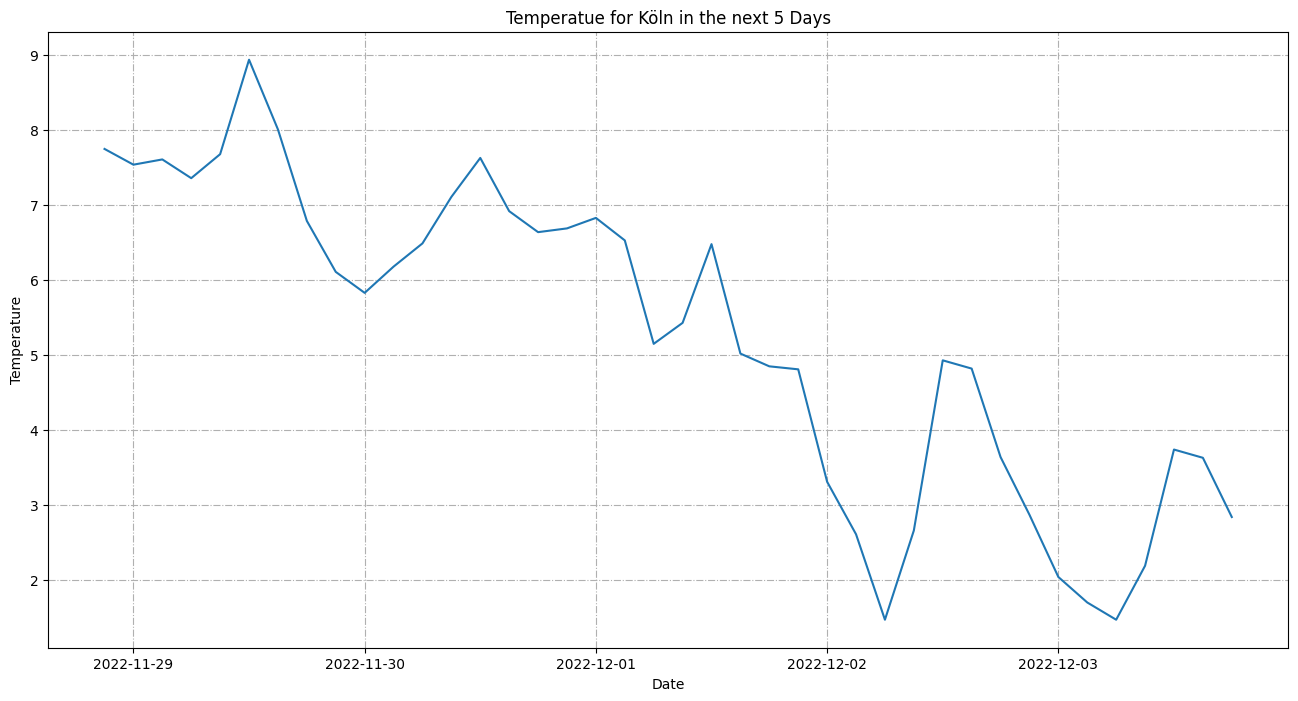

In [119]:
# Set up the canvas
fig, ax = plt.subplots(figsize=(16, 8))

# Add a line at zero
ax.plot(df_t["date"], df_t["temp"])
    
# Beautify the plots
ax.grid(linestyle="dashdot")
ax.set_ylabel("Temperature")
ax.set_xlabel("Date")
ax.set_title("Temperatue for Köln in the next 5 Days");